In [1]:
!pip install -q underthesea
!pip install -q rouge-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Import thư viện

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import os
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
from torch.optim import AdamW
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import seaborn as sns
import pandas as pd
from transformers import AutoTokenizer, ViTFeatureExtractor, AutoModel, CLIPImageProcessor, AutoTokenizer, AutoImageProcessor, ViTModel
from transformers import BlipProcessor, BlipForConditionalGeneration
from datasets import load_dataset
from datasets import load_dataset, Features, Value
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
import os
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import Counter
from underthesea import word_tokenize, text_normalize
import re
import string
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from nltk.translate.bleu_score import corpus_bleu
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer
from sentence_transformers import SentenceTransformer, util

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 1
MAX_LEN = 100
EPOCHS = 2

2025-05-17 20:30:45.304299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747513845.551945      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747513845.623906      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Import data

In [3]:
root_dir = "/kaggle/input/data-nlp-bai-2/data"
df_1 = pd.DataFrame()
for path in os.listdir(root_dir):
  df = pd.read_csv(os.path.join(root_dir, path))
  df_1 = pd.concat([df, df_1])
df_1

,image_path,description,question,answer
0,12006.jpg,"Bức ảnh hiển thị một phần tài liệu khoa học, c...","Theo bạn, thí nghiệm này có thể được áp dụng t...",Thí nghiệm này có thể được áp dụng trong thực ...
1,12007.jpg,"Bức ảnh hiển thị một bảng mục lục với 3 cột, m...",Bài học nào được liệt kê trong tuần 20?,Tuần 20 bao gồm các bài học sau: \n- Đọc thơ\...
2,12007.jpg,"Bức ảnh hiển thị một bảng mục lục với 3 cột, m...","Bài ""Luyện tập về thao tác lập luận bác bỏ"" xu...","Bài ""Luyện tập về thao tác lập luận bác bỏ"" xu..."
3,12007.jpg,"Bức ảnh hiển thị một bảng mục lục với 3 cột, m...","Bài đọc thêm ""Tổng biệt hành"" nằm trong tuần nào?","Bài đọc thêm ""Tổng biệt hành"" nằm trong tuần 23."
4,12007.jpg,"Bức ảnh hiển thị một bảng mục lục với 3 cột, m...","Bài ""Tráng giang"" của tác giả nào?","Bài ""Tráng giang"" là của tác giả Huy Cận."
...,...,...,...,...
19091,51855.jpg,Bức ảnh bao gồm hai phần chính. Phần trên là c...,Câu hỏi 1 đề cập đến vấn đề gì?,Câu hỏi 1 đề cập đến khả năng lưu trữ văn bản ...
19092,51855.jpg,Bức ảnh bao gồm hai phần chính. Phần trên là c...,Câu hỏi 2 đề cập đến các biện pháp bảo vệ dữ l...,Câu hỏi 2 đề cập đến 5 biện pháp bảo vệ dữ liệ...
19093,51855.jpg,Bức ảnh bao gồm hai phần chính. Phần trên là c...,Hình ảnh minh họa cho câu hỏi 1 là gì?,Hình ảnh minh họa cho câu hỏi 1 là 4 khung tho...
19094,51855.jpg,Bức ảnh bao gồm hai phần chính. Phần trên là c...,Hình ảnh minh họa cho phần bài tập vận dụng là...,Hình ảnh minh họa cho phần bài tập vận dụng là...


In [4]:
root_dir = "/kaggle/input/data-nlp-bai-2/Data_genarative/Data_genarative"
df_gen1 = pd.DataFrame()
for path in os.listdir(root_dir):
  df = pd.read_csv(os.path.join(root_dir, path))
  df_gen1 = pd.concat([df, df_gen1])
df_gen1

,image_path,description,question,answer
0,1271.jpg,"Ảnh là một trang sách, có tiêu đề ""Thực hành"",...","Theo tài liệu, cần những vật liệu gì để thực h...","Để nhận diện các dòng lợn, tài liệu hướng dẫn ..."
1,1271.jpg,"Ảnh là một trang sách, có tiêu đề ""Thực hành"",...","Theo tài liệu, cần những vật liệu gì để thực h...","Tài liệu yêu cầu học viên sử dụng tranh ảnh, l..."
2,1271.jpg,"Ảnh là một trang sách, có tiêu đề ""Thực hành"",...",Bước đầu tiên trong quy trình thực hành nhận b...,Bắt đầu quy trình thực hành bằng cách nhận diệ...
3,1271.jpg,"Ảnh là một trang sách, có tiêu đề ""Thực hành"",...",Bước đầu tiên trong quy trình thực hành nhận b...,"Đầu tiên, hãy xem xét hình dáng bên ngoài của ..."
4,1271.jpg,"Ảnh là một trang sách, có tiêu đề ""Thực hành"",...",Hình ảnh minh họa cho bước 1 trong quy trình t...,Bước đầu tiên trong quy trình thực hiện được l...
...,...,...,...,...
1799,1232.jpg,"Bức ảnh bao gồm phần tiêu đề chính là ""VẬN ĐỘN...",Chúng ta có thể hiểu thêm gì về bài học nhờ bứ...,"Bức ảnh giới thiệu nội dung chính là ""Chạy cự ..."
1800,1233.jpg,Bức ảnh chụp một trang sách giáo khoa Toán học...,Diện tích vỏ ngoài và tổng diện tích bề mặt củ...,Công thức tính diện tích xung quanh của hình t...
1801,1233.jpg,Bức ảnh chụp một trang sách giáo khoa Toán học...,Để xác định diện tích xung quanh và diện tích ...,Công thức tính diện tích xung quanh của hình t...
1802,1233.jpg,Bức ảnh chụp một trang sách giáo khoa Toán học...,Thể tích của hình trụ được tính như thế nào?,Công thức tính thể tích hình trụ là V = Sh = π...


# Xử lý data

In [5]:
def processing_df(df, root_dir):
    df = df.rename({"image_path": "image_id"}, axis = 1)
    df["image_path"] = df['image_id'].apply(lambda x: os.path.join(root_dir, x))
    df["image_id"] = df["image_id"].str.split(".").str[0]
    df = df.dropna().copy()
    df = df[df['image_path'] != '/kaggle/input/data-nlp-bai-2/img/img/6803.jpg']
    df = df[df['image_path'] != '/kaggle/input/data-nlp-bai-2/img/img/6801.jpg']
    df['question'] = df['question'].astype(str)
    df['answer'] = df['answer'].astype(str)
    df.drop(['description'], axis = 1, inplace = True)
    df.drop_duplicates(inplace = True, ignore_index = True)
    df.reset_index(inplace=True)
    return df

In [6]:
df = processing_df(df_1, '/kaggle/input/data-nlp-bai-2/img/img')
# df = df.iloc[:100]
df

,index,image_id,question,answer,image_path
0,0,12006,"Theo bạn, thí nghiệm này có thể được áp dụng t...",Thí nghiệm này có thể được áp dụng trong thực ...,/kaggle/input/data-nlp-bai-2/img/img/12006.jpg
1,1,12007,Bài học nào được liệt kê trong tuần 20?,Tuần 20 bao gồm các bài học sau: \n- Đọc thơ\...,/kaggle/input/data-nlp-bai-2/img/img/12007.jpg
2,2,12007,"Bài ""Luyện tập về thao tác lập luận bác bỏ"" xu...","Bài ""Luyện tập về thao tác lập luận bác bỏ"" xu...",/kaggle/input/data-nlp-bai-2/img/img/12007.jpg
3,3,12007,"Bài đọc thêm ""Tổng biệt hành"" nằm trong tuần nào?","Bài đọc thêm ""Tổng biệt hành"" nằm trong tuần 23.",/kaggle/input/data-nlp-bai-2/img/img/12007.jpg
4,4,12007,"Bài ""Tráng giang"" của tác giả nào?","Bài ""Tráng giang"" là của tác giả Huy Cận.",/kaggle/input/data-nlp-bai-2/img/img/12007.jpg
...,...,...,...,...,...
259055,259055,51855,Câu hỏi 1 đề cập đến vấn đề gì?,Câu hỏi 1 đề cập đến khả năng lưu trữ văn bản ...,/kaggle/input/data-nlp-bai-2/img/img/51855.jpg
259056,259056,51855,Câu hỏi 2 đề cập đến các biện pháp bảo vệ dữ l...,Câu hỏi 2 đề cập đến 5 biện pháp bảo vệ dữ liệ...,/kaggle/input/data-nlp-bai-2/img/img/51855.jpg
259057,259057,51855,Hình ảnh minh họa cho câu hỏi 1 là gì?,Hình ảnh minh họa cho câu hỏi 1 là 4 khung tho...,/kaggle/input/data-nlp-bai-2/img/img/51855.jpg
259058,259058,51855,Hình ảnh minh họa cho phần bài tập vận dụng là...,Hình ảnh minh họa cho phần bài tập vận dụng là...,/kaggle/input/data-nlp-bai-2/img/img/51855.jpg


In [7]:
df_gen = processing_df(df_gen1, '/kaggle/input/data-nlp-bai-2/img/img')
# df_gen = df_gen.iloc[:100]
df_gen

,index,image_id,question,answer,image_path
0,0,1271,"Theo tài liệu, cần những vật liệu gì để thực h...","Để nhận diện các dòng lợn, tài liệu hướng dẫn ...",/kaggle/input/data-nlp-bai-2/img/img/1271.jpg
1,1,1271,"Theo tài liệu, cần những vật liệu gì để thực h...","Tài liệu yêu cầu học viên sử dụng tranh ảnh, l...",/kaggle/input/data-nlp-bai-2/img/img/1271.jpg
2,2,1271,Bước đầu tiên trong quy trình thực hành nhận b...,Bắt đầu quy trình thực hành bằng cách nhận diệ...,/kaggle/input/data-nlp-bai-2/img/img/1271.jpg
3,3,1271,Bước đầu tiên trong quy trình thực hành nhận b...,"Đầu tiên, hãy xem xét hình dáng bên ngoài của ...",/kaggle/input/data-nlp-bai-2/img/img/1271.jpg
4,4,1271,Hình ảnh minh họa cho bước 1 trong quy trình t...,Bước đầu tiên trong quy trình thực hiện được l...,/kaggle/input/data-nlp-bai-2/img/img/1271.jpg
...,...,...,...,...,...
180116,180116,22014,Hai câu văn (1b) và (1c) cùng nói về điều gì?,Hai câu văn (1b) và (1c) đều miêu tả việc trả ...,/kaggle/input/data-nlp-bai-2/img/img/22014.jpg
180117,180117,22014,Điểm khác biệt giữa câu văn thứ hai và câu văn...,"Theo nội dung trong bức ảnh, hai câu văn (2) v...",/kaggle/input/data-nlp-bai-2/img/img/22014.jpg
180118,180118,22014,Hai câu (2) và (3) trong bức ảnh có sự khác nh...,"Theo nội dung trong bức ảnh, hai câu văn (2) v...",/kaggle/input/data-nlp-bai-2/img/img/22014.jpg
180119,180119,22014,Hai câu văn (4) và (5) minh chứng cho sắc thái...,Hai câu văn (4) và (5) là dẫn chứng cho nghĩa ...,/kaggle/input/data-nlp-bai-2/img/img/22014.jpg


In [8]:
print("NaN trong df:")
print(df.isna().sum())
print("\nNaN trong df_gen:")
print(df_gen.isna().sum())

NaN trong df:
index         0
image_id      0
question      0
answer        0
image_path    0
dtype: int64

NaN trong df_gen:
index         0
image_id      0
question      0
answer        0
image_path    0
dtype: int64


# Số dòng dữ liệu

In [9]:
print(f"Số data gốc: {len(df)}")
print(f"Số data tạo ra: {len(df_gen)}")

Số data gốc: 259060
Số data tạo ra: 180121


# So sánh độ tương đồng

In [10]:
def calculate_similarity(text1, text2):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([text1, text2])
    return cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]

In [11]:
# Xử lý dữ liệu
df_gen_filtered = df_gen.copy()
df_gen_filtered['similarity'] = np.nan
mask = pd.Series(False, index=df_gen.index)  # Mặc định bỏ tất cả

# Duyệt qua từng dòng trong df_gen với tqdm
for idx in tqdm(df_gen.index, desc="Xử lý các dòng trong df_gen"):
    question_gen = df_gen.loc[idx, 'question']
    answer_gen = df_gen.loc[idx, 'answer']
    
    # Kiểm tra xem câu hỏi hoặc câu trả lời có tồn tại trong df_1 không
    question_exists = question_gen in df_1['question'].values
    answer_exists = answer_gen in df_1['answer'].values
    
    if question_exists or answer_exists:
        if question_exists:
            # Nếu câu hỏi tồn tại, so sánh câu trả lời
            matched_row = df_1[df_1['question'] == question_gen].iloc[0]
            text_gen = answer_gen
            text_df1 = matched_row['answer']
        else:
            # Nếu câu trả lời tồn tại, so sánh câu hỏi
            matched_row = df_1[df_1['answer'] == answer_gen].iloc[0]
            text_gen = question_gen
            text_df1 = matched_row['question']
        
        similarity = calculate_similarity(text_gen, text_df1)
        df_gen.loc[idx, 'similarity'] = similarity
        
        # Đánh dấu để lọc df_gen_filtered
        if similarity > 0.5:
            mask[idx] = True

# Tạo df_gen_filtered chứa các dòng có độ tương đồng > 0.6
df_gen_filtered = df_gen[mask]

# In số lượng dòng trước và sau khi lọc
print(f"Số dòng trong df_gen ban đầu: {len(df_gen)}")
print(f"Số dòng trong df_gen_filtered: {len(df_gen_filtered)}")

Xử lý các dòng trong df_gen: 100%|██████████| 180121/180121 [3:09:00<00:00, 15.88it/s]


Số dòng trong df_gen ban đầu: 180121
Số dòng trong df_gen_filtered: 41590


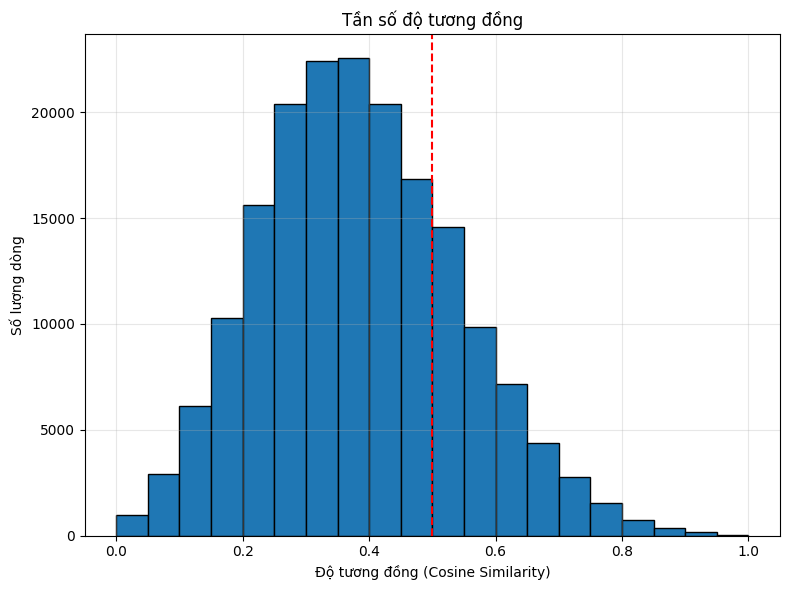

In [12]:
# Vẽ biểu đồ tần số độ tương đồng
plt.figure(figsize=(8, 6))
plt.hist(df_gen['similarity'], bins=20, color='#1f77b4', edgecolor='black')
plt.axvline(x=0.5, color='red', linestyle='--', label='Ngưỡng 0.5')  # Thêm đường chặn
plt.title('Tần số độ tương đồng')
plt.xlabel('Độ tương đồng (Cosine Similarity)')
plt.ylabel('Số lượng dòng')
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [13]:
df_gen_filtered = df_gen_filtered.drop(['similarity'], axis = 1)
df_all = pd.concat([df, df_gen_filtered])
df_all

,index,image_id,question,answer,image_path
0,0,12006,"Theo bạn, thí nghiệm này có thể được áp dụng t...",Thí nghiệm này có thể được áp dụng trong thực ...,/kaggle/input/data-nlp-bai-2/img/img/12006.jpg
1,1,12007,Bài học nào được liệt kê trong tuần 20?,Tuần 20 bao gồm các bài học sau: \n- Đọc thơ\...,/kaggle/input/data-nlp-bai-2/img/img/12007.jpg
2,2,12007,"Bài ""Luyện tập về thao tác lập luận bác bỏ"" xu...","Bài ""Luyện tập về thao tác lập luận bác bỏ"" xu...",/kaggle/input/data-nlp-bai-2/img/img/12007.jpg
3,3,12007,"Bài đọc thêm ""Tổng biệt hành"" nằm trong tuần nào?","Bài đọc thêm ""Tổng biệt hành"" nằm trong tuần 23.",/kaggle/input/data-nlp-bai-2/img/img/12007.jpg
4,4,12007,"Bài ""Tráng giang"" của tác giả nào?","Bài ""Tráng giang"" là của tác giả Huy Cận.",/kaggle/input/data-nlp-bai-2/img/img/12007.jpg
...,...,...,...,...,...
180082,180082,22010,Số lượng học sinh lớp Lan đã ăn sáng bằng món ...,Có 2 bạn học sinh trong lớp Lan ăn sáng 'Phở'.,/kaggle/input/data-nlp-bai-2/img/img/22010.jpg
180092,180092,22011,Bức ảnh nào trong 4 bức ảnh chụp được nhiều lo...,"Bức ảnh ""Hình 37.2. Voọc quần đuôi trắng"" thể ...",/kaggle/input/data-nlp-bai-2/img/img/22011.jpg
180099,180099,22012,Nguyên tử khác nguyên tố hóa học ở điểm nào?,"Theo bài học, số proton trong hạt nhân chính ...",/kaggle/input/data-nlp-bai-2/img/img/22012.jpg
180100,180100,22012,Đâu là điểm khác biệt cơ bản giữa nguyên tử và...,"Theo bài học, số proton trong hạt nhân chính ...",/kaggle/input/data-nlp-bai-2/img/img/22012.jpg


In [14]:
def normalize_text(text):
    clean_text = text.lower()

    replacements = {
        "nxb": "nhà xuất bản",
    }

    for old, new in replacements.items():
        clean_text = clean_text.replace(old, new)

    # Xóa ký tự đặc biệt VD (&nbsp;)
    clean_text = re.sub(r'&\S+;', ' ', clean_text)

    # Xóa emoji
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               "]+", flags=re.UNICODE)
    clean_text = re.sub(emoji_pattern, " ", clean_text)

    # Xóa ký tự đặc biệt không gõ được
    special_chars = ["“", "”", "…", "•", "–", "’", " ️", "✅", "✓", " ̂́ ̃ ̣̂ ", "‘", "●", "‒", "➤",
                     "★", "ღ", "✪", "‎", "➦", "×", "", "✿", "☆", "◤", "◕", "❁", "‿",
                     "❀", "■", "█", "☛", "⑴⒪⑵⑵⑴⑺", "►", "°", "»", "ø", "➽", "", "✧", "✽", "*",
                     "➫", "【", "】", "⇒", "卐", "♛", "±", "∞", "②", "⑥", "①", "⑦", "➋", "➊", "➌",
                     "✓", "™", "®", "", ""]
    for char in special_chars:
        clean_text = clean_text.replace(char, " ")

    # Bỏ các ký tự đặc biệt (dấu câu)
    clean_text = ''.join(' ' if char in string.punctuation else char for char in clean_text)

    # Loại bỏ khoảng trắng thừa
    clean_text = re.sub(r"\s+", " ", clean_text)
    clean_text = re.sub(r"^[\s]", "", clean_text)
    clean_text = re.sub(r"[\s]$", "", clean_text)

    # Đảm bảo dấu ở đúng chữ (ví dụ: oà, uý)
    clean_text = text_normalize(clean_text)

    # Tách câu thành từ
    clean_text = word_tokenize(clean_text, format="text")

    return clean_text

def apply_normalize_text_to_dataframe(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: normalize_text(str(x)))
    return df

In [15]:
columns_to_process = ['question', 'answer']
df_all = apply_normalize_text_to_dataframe(df_all, columns_to_process)
df = apply_normalize_text_to_dataframe(df, columns_to_process)
df_all

,index,image_id,question,answer,image_path
0,0,12006,theo bạn thí_nghiệm này có_thể được áp_dụng tr...,thí_nghiệm này có_thể được áp_dụng trong thực_...,/kaggle/input/data-nlp-bai-2/img/img/12006.jpg
1,1,12007,bài_học nào được liệt_kê trong tuần 20,tuần 20 bao_gồm các bài_học sau đọc thơ_nghĩa ...,/kaggle/input/data-nlp-bai-2/img/img/12007.jpg
2,2,12007,bài luyện_tập về thao_tác lập_luận bác_bỏ xuất...,bài luyện_tập về thao_tác lập_luận bác_bỏ xuất...,/kaggle/input/data-nlp-bai-2/img/img/12007.jpg
3,3,12007,bài đọc thêm tổng_biệt_hành nằm trong tuần nào,bài đọc thêm tổng_biệt_hành nằm trong tuần 23,/kaggle/input/data-nlp-bai-2/img/img/12007.jpg
4,4,12007,bài tráng_giang của tác_giả nào,bài tráng_giang là của tác_giả huy_cận,/kaggle/input/data-nlp-bai-2/img/img/12007.jpg
...,...,...,...,...,...
180082,180082,22010,số_lượng học_sinh lớp lan đã ăn sáng bằng món ...,có 2 bạn học_sinh trong lớp lan ăn sáng phở,/kaggle/input/data-nlp-bai-2/img/img/22010.jpg
180092,180092,22011,bức ảnh nào trong 4 bức ảnh chụp được nhiều lo...,bức ảnh hình 37 2 voọc quần_đuôi trắng thể_hiệ...,/kaggle/input/data-nlp-bai-2/img/img/22011.jpg
180099,180099,22012,nguyên_tử khác nguyên_tố hóa_học ở điểm nào,theo bài_học số proton trong hạt_nhân chính là...,/kaggle/input/data-nlp-bai-2/img/img/22012.jpg
180100,180100,22012,đâu là điểm khác_biệt cơ_bản giữa nguyên_tử và...,theo bài_học số proton trong hạt_nhân chính là...,/kaggle/input/data-nlp-bai-2/img/img/22012.jpg


# Trực quan hóa dữ liệu

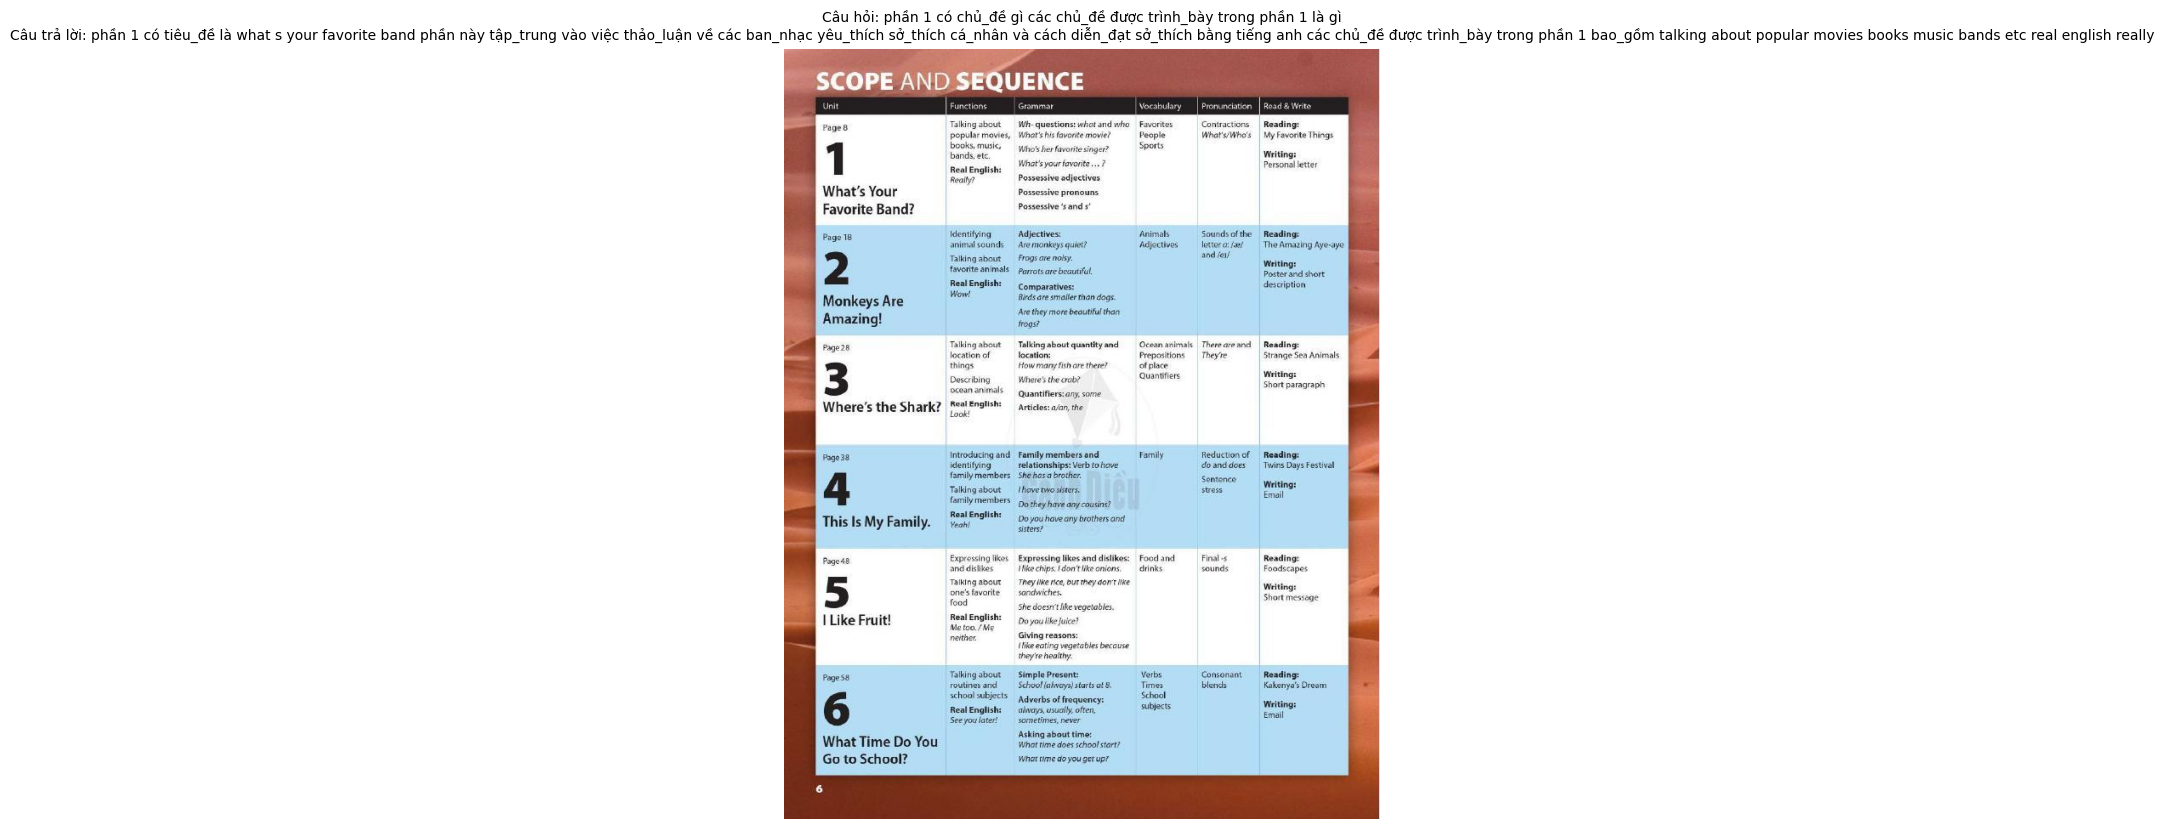

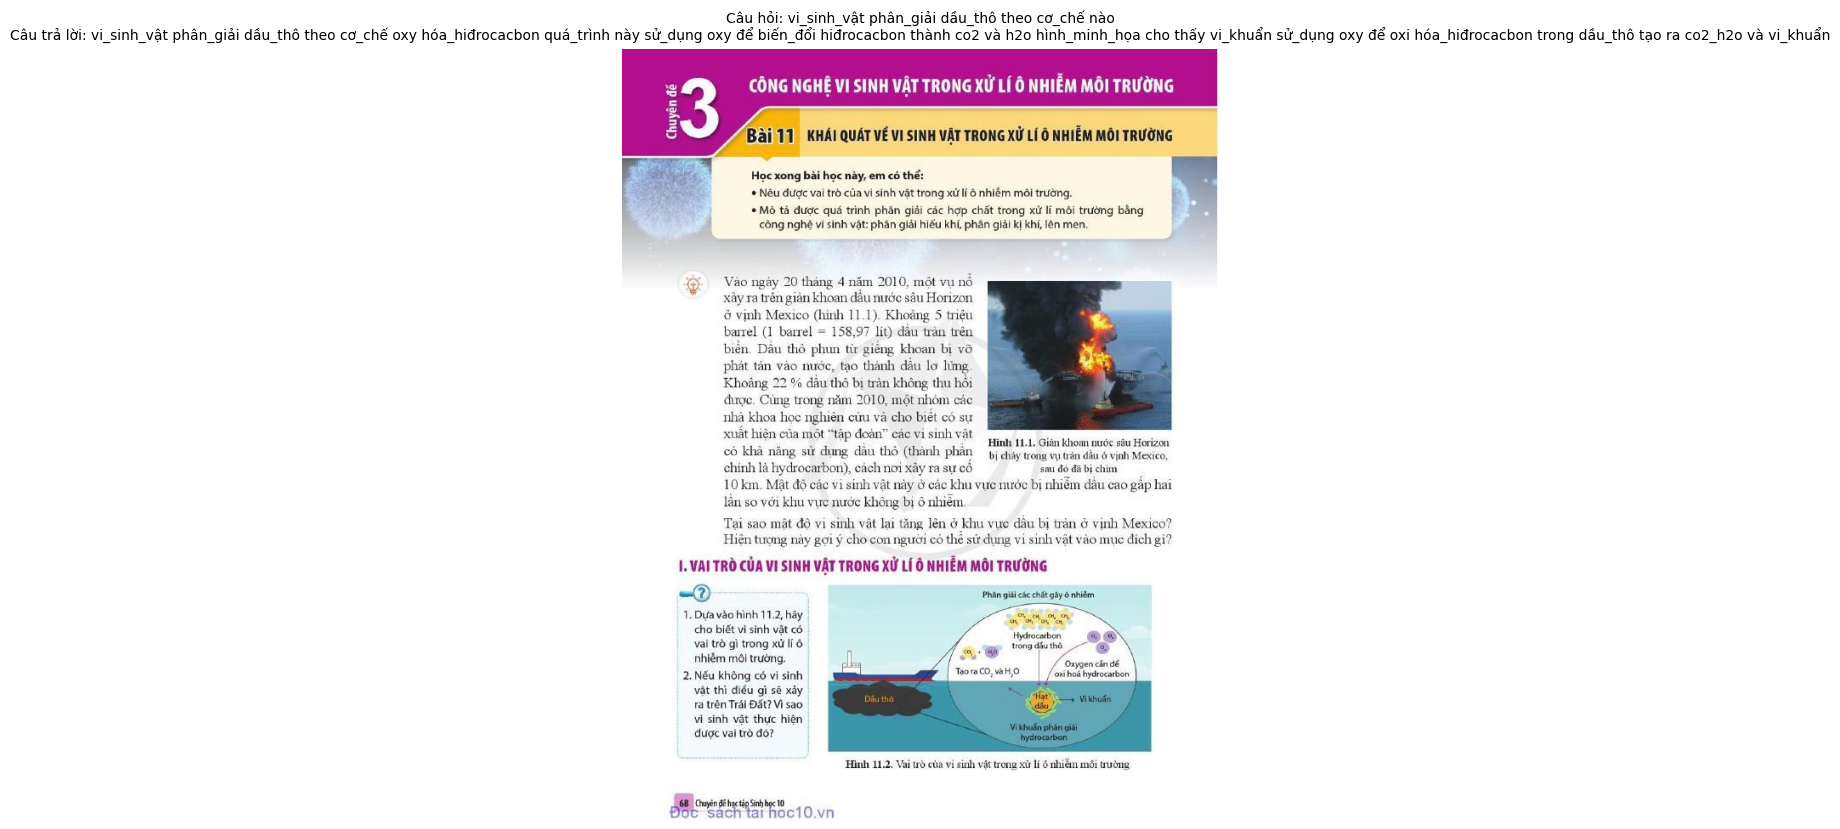

In [16]:
samples = df_all.sample(n=random.randint(2, min(2, len(df_all)))).reset_index(drop=True)

for i, row in samples.iterrows():
    image = row['image_path']
    question = row['question']
    answer = row['answer']

    try:
        # Mở và hiển thị hình ảnh
        img = Image.open(image)

        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.title(f"Câu hỏi: {question}\nCâu trả lời: {answer}", fontsize=10)
        plt.axis('off')  # Ẩn trục để hiển thị gọn gàng hơn
        plt.show()
    except FileNotFoundError:
        print(f"Không tìm thấy hình ảnh: {image}")
    except Exception as e:
        print(f"Lỗi khi tải hình ảnh {image}: {e}")

In [17]:
def get_sentence_length(text):
    if not isinstance(text, str):
        return 0
    tokens = word_tokenize(text)
    return len(tokens)

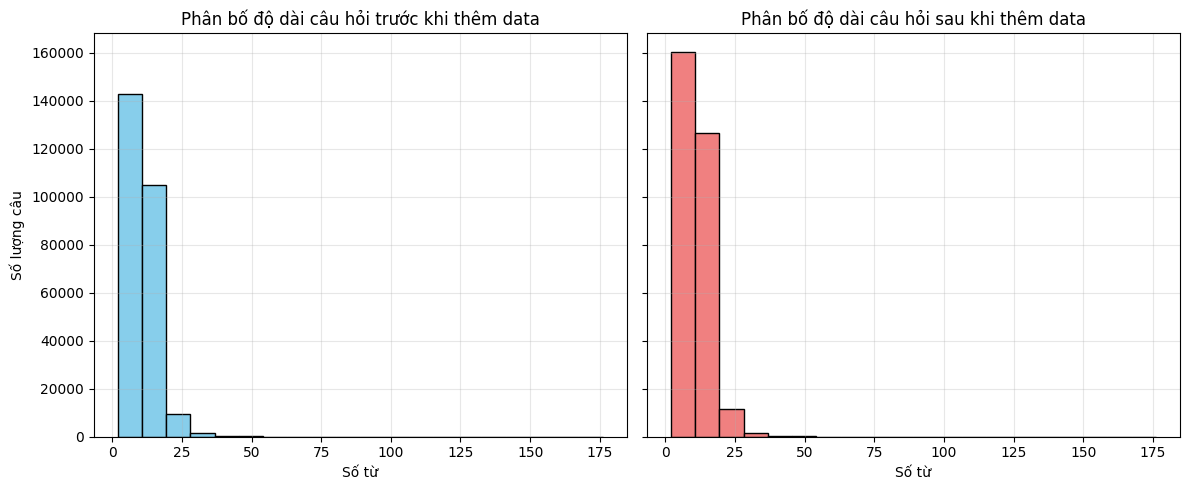

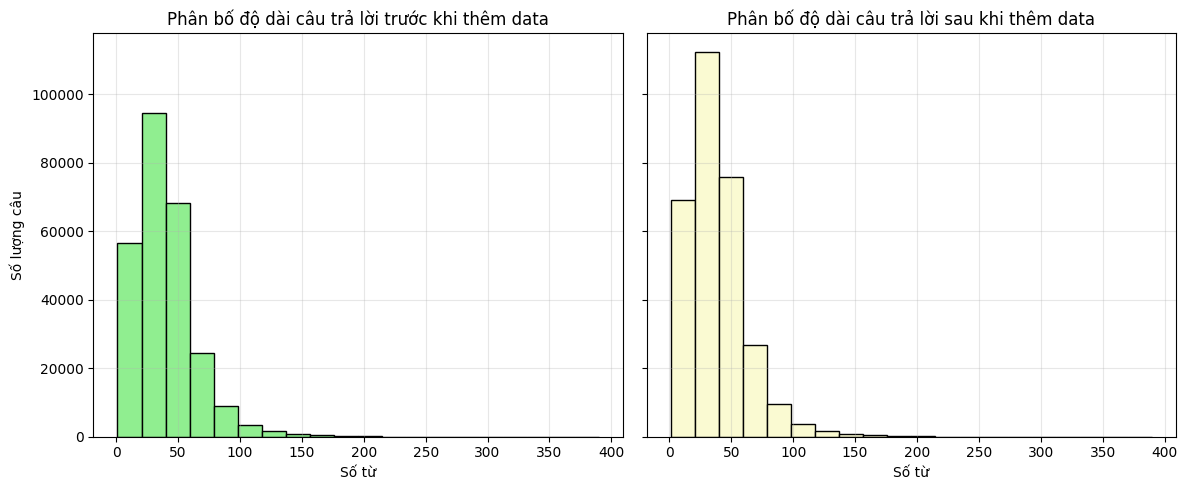

In [18]:
question_lengths_df = df['question'].apply(get_sentence_length).tolist()
answer_lengths_df = df['answer'].apply(get_sentence_length).tolist()
question_lengths_df_all = df_all['question'].apply(get_sentence_length).tolist()
answer_lengths_df_all = df_all['answer'].apply(get_sentence_length).tolist()

# Hình 1: Phân bố độ dài câu hỏi
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Biểu đồ 1: Độ dài câu hỏi trong df
ax1.hist(question_lengths_df, bins=20, color='skyblue', edgecolor='black')
ax1.set_title('Phân bố độ dài câu hỏi trước khi thêm data')
ax1.set_xlabel('Số từ')
ax1.set_ylabel('Số lượng câu')
ax1.grid(True, alpha=0.3)

# Biểu đồ 2: Độ dài câu hỏi trong df_all
ax2.hist(question_lengths_df_all, bins=20, color='lightcoral', edgecolor='black')
ax2.set_title('Phân bố độ dài câu hỏi sau khi thêm data')
ax2.set_xlabel('Số từ')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Hình 2: Phân bố độ dài câu trả lời
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Biểu đồ 3: Độ dài câu trả lời trong df
ax3.hist(answer_lengths_df, bins=20, color='lightgreen', edgecolor='black')
ax3.set_title('Phân bố độ dài câu trả lời trước khi thêm data')
ax3.set_xlabel('Số từ')
ax3.set_ylabel('Số lượng câu')
ax3.grid(True, alpha=0.3)

# Biểu đồ 4: Độ dài câu trả lời trong df_all
ax4.hist(answer_lengths_df_all, bins=20, color='lightgoldenrodyellow', edgecolor='black')
ax4.set_title('Phân bố độ dài câu trả lời sau khi thêm data')
ax4.set_xlabel('Số từ')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Train test split

In [19]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
df_train, df_test = train_test_split(df_all, test_size=0.2, random_state=42)

# Kiểm tra kích thước
print("Number of rows in train set:", len(df_train))
print("Number of rows in test set:", len(df_test))
print("Train set columns:", df_train.columns)
print("Test set columns:", df_test.columns)

Number of rows in train set: 240520
Number of rows in test set: 60130
Train set columns: Index(['index', 'image_id', 'question', 'answer', 'image_path'], dtype='object')
Test set columns: Index(['index', 'image_id', 'question', 'answer', 'image_path'], dtype='object')


In [20]:
df_train.head()

,index,image_id,question,answer,image_path
226722,226722,39373,khi sử_dụng keo dán ure fomandehit cần lưu_ý đ...,khi sử_dụng keo dán ure fomandehit cần lưu_ý p...,/kaggle/input/data-nlp-bai-2/img/img/39373.jpg
172151,172151,4439,điều_kiện để áp_dụng tính_chất thứ 6 là gì,điều_kiện để áp_dụng tính_chất thứ 6 là a 0,/kaggle/input/data-nlp-bai-2/img/img/4439.jpg
212839,212839,36593,trong thí_nghiệm khi khóa_k ở vị_trí ngắt_điện...,khi khóa_k ở vị_trí ngắt_điện off miliampe_kế ...,/kaggle/input/data-nlp-bai-2/img/img/36593.jpg
36988,36988,25414,phần văn_bản vận_dụng sáng_tạo giới_thiệu bài_...,phần văn_bản vận_dụng sáng_tạo giới_thiệu một ...,/kaggle/input/data-nlp-bai-2/img/img/25414.jpg
104606,104606,8931,câu hỏi được đặt ra ở cuối bài_học là gì,câu hỏi được đặt ra ở cuối bài_học là quan_sát...,/kaggle/input/data-nlp-bai-2/img/img/8931.jpg


In [21]:
df_train.to_csv("df_train.csv", index=False)

In [22]:
df_test.head()

,index,image_id,question,answer,image_path
95956,95956,10757,để đo_suất điện_động e và điện trở trong r của...,mắc vôn_kế v vào hai đầu đoạn mạch mn là phươn...,/kaggle/input/data-nlp-bai-2/img/img/10757.jpg
47881,47881,27595,vì sao gia_súc ăn cỏ được nuôi nhiều ở khu_vực...,gia_súc ăn cỏ được nuôi phổ_biến ở nơi có nhiề...,/kaggle/input/data-nlp-bai-2/img/img/27595.jpg
142,142,12035,trong bảng của bài_toán số 2 cột 1 thể_hiện đơ...,cột 1 của bảng trong bài_toán số 2 sử_dụng đơn...,/kaggle/input/data-nlp-bai-2/img/img/12035.jpg
80956,80956,46219,yếu_tố kinh_tế xã_hội nào ảnh_hưởng trực_tiếp ...,yếu_tố kinh_tế xã_hội ảnh_hưởng trực_tiếp đến ...,/kaggle/input/data-nlp-bai-2/img/img/46219.jpg
230685,230685,40167,văn_bản có đề_cập đến những khó_khăn nào mà ng...,văn_bản đề_cập đến những khó_khăn mà người_dân...,/kaggle/input/data-nlp-bai-2/img/img/40167.jpg


In [23]:
df_test.to_csv("df_test.csv", index=False)